In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = [8, 6]
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.grid'] = True

import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
torch.multiprocessing.set_start_method('spawn')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


import numpy as np
SEED=12345
_=np.random.seed(SEED)
_=torch.manual_seed(SEED)

import networkx as nx

from iftool.image_challenge import collate
from torch.utils.data import DataLoader

from iftool.image_challenge import ParticleImage2D
from torch_geometric.utils import from_networkx

## Load data

In [4]:
train_graphs = torch.load("/ssl-jet-vol-v2/ssi_2023_if_1/data/train_graphs_2.pt")

In [5]:
len(train_graphs)

40000

In [12]:
test_graphs = torch.load("/ssl-jet-vol-v2/ssi_2023_if_1/data/test_graphs_2.pt")

In [13]:
len(test_graphs)

100000

In [17]:
val_ratio = 0.1
train_data = train_graphs[:int(len(train_graphs) * (1 - val_ratio))]
val_data = train_graphs[int(len(train_graphs) * (1 - val_ratio)):]

In [18]:
len(train_data)

36000

In [19]:
len(val_data)

4000

In [20]:
from torch_geometric.data import DataLoader

# Assuming list_of_data is your loaded list of Data objects
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
val_loader = DataLoader(val_data, batch_size=256, shuffle=True)

In [7]:
for batch in train_loader:
    break

In [22]:
batch.y

tensor([0, 2, 3, 1, 2, 0, 1, 2, 0, 2, 2, 2, 2, 1, 2, 1, 3, 1, 0, 2, 3, 1, 1, 1,
        3, 2, 1, 3, 2, 3, 1, 0, 3, 3, 3, 1, 0, 1, 1, 3, 1, 1, 0, 1, 1, 1, 0, 3,
        3, 0, 1, 0, 1, 0, 3, 0, 2, 3, 0, 3, 3, 0, 1, 3, 0, 1, 1, 1, 2, 2, 0, 0,
        2, 3, 2, 0, 3, 2, 3, 1, 2, 2, 0, 3, 2, 0, 3, 1, 2, 1, 1, 0, 1, 2, 1, 1,
        1, 3, 0, 1, 2, 0, 2, 3, 2, 1, 2, 3, 1, 1, 0, 2, 3, 0, 0, 1, 0, 2, 0, 1,
        3, 3, 1, 1, 0, 0, 2, 1, 2, 2, 1, 3, 1, 1, 2, 1, 3, 3, 1, 2, 3, 0, 1, 1,
        1, 2, 2, 2, 0, 0, 3, 0, 2, 2, 1, 0, 0, 0, 0, 0, 0, 3, 3, 0, 1, 0, 0, 0,
        2, 2, 1, 3, 3, 2, 3, 2, 0, 0, 1, 2, 2, 2, 3, 2, 0, 2, 0, 3, 3, 2, 2, 0,
        3, 3, 0, 2, 1, 2, 0, 2, 3, 1, 0, 2, 1, 3, 0, 0, 1, 0, 3, 0, 1, 2, 1, 0,
        1, 3, 1, 3, 3, 0, 2, 0, 1, 0, 2, 2, 0, 3, 1, 0, 1, 1, 2, 1, 1, 0, 3, 3,
        2, 0, 0, 3, 0, 1, 2, 1, 3, 2, 3, 0, 2, 2, 0, 0])

In [36]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(1, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 4)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = x.reshape(-1, 1)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [44]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GraphConv, GATConv
from torch_geometric.nn import global_mean_pool


class GrCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GrCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(1, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 4)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = x.reshape(-1, 1)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [55]:
class GATCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GATCN, self).__init__()
        torch.manual_seed(12345)
        self.hidden_channels = hidden_channels
        self.conv1 = GATConv(1, hidden_channels, heads=1, concat=False)
        self.conv2 = GATConv(hidden_channels, hidden_channels, heads=2, concat=False)
        self.conv3 = GATConv(hidden_channels, hidden_channels, heads=2, concat=False)
        self.lin = Linear(hidden_channels, 4)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = x.reshape(-1, 1)
        x = self.conv1(x, edge_index)
        x = x.relu()
#         x = self.conv2(x, edge_index).reshape(-1, self.hidden_channels*2)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [68]:
class GrCN_2(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GrCN_2, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(1, int(hidden_channels / 2))
        self.conv2 = GraphConv(int(hidden_channels / 2), hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.conv4 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 4)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = x.reshape(-1, 1)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [71]:
model = GrCN_2(hidden_channels=256).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

label = "GraphConv_large"
outdir = "/ssl-jet-vol-v2/ssi_2023_if_1/models"
model_loc = f"{outdir}/trained_models/"
model_perf_loc = f"{outdir}/model_performances/{label}"

train_its = int(len(train_data) / batch_size)
val_its = int(len(val_data) / batch_size)

train_losses = []
val_losses = []
val_accs = []
val_acc_best = 0
epochs = 50

for epoch in range(epochs):
    l_train_epoch = []
    l_val_epoch = []
    model.train()
    pbar = tqdm.tqdm(train_loader, total=train_its)
    for _, bb in enumerate(pbar):
        bb.to(device)
        out = model(bb.value, bb.edge_index, bb.batch)  # Perform a single forward pass.
        loss = criterion(out, bb.y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss = loss.detach().cpu().item()
        l_train_epoch.append(loss)
        pbar.set_description(f"Training loss: {loss:.4f}")

    l_train = np.mean(l_train_epoch)
    train_losses.append(l_train)
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {l_train:.4f} ")

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        pbar = tqdm.tqdm(val_loader, total=val_its)
        for i, bb in enumerate(pbar):
            bb.to(device)
            out = model(bb.value, bb.edge_index, bb.batch)  # Perform a single forward pass.
            loss = criterion(out, bb.y)
            
            
            labels = bb.y
            loss = loss.detach().cpu().item()
            l_val_epoch.append(loss)
            pbar.set_description(f"Validation loss: {loss:.4f}")
            _, predicted = torch.max(out.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            

    val_acc = correct / total
    print(f"val accuracy: {val_acc}")
    val_accs.append(val_acc)

    l_val = np.mean(l_val_epoch)
    print(f"Epoch [{epoch+1}/{epochs}], Val Loss: {l_val:.4f} ")
    if val_acc > val_acc_best:
        val_acc_best = val_acc
        print("new best model")
        torch.save(model.state_dict(), f"{model_loc}/GNN_{label}_best.pth")
    torch.save(model.state_dict(), f"{model_loc}/GNN_{label}_last.pth")
    val_losses.append(l_val)



Training loss: 0.3560:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.33it/s]


Epoch [1/50], Train Loss: 11.1132 


Validation loss: 0.4070:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 28.24it/s]


val accuracy: 0.81075
Epoch [1/50], Val Loss: 0.3804 
new best model


Training loss: 0.3825:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.08it/s]


Epoch [2/50], Train Loss: 0.3974 


Validation loss: 0.3242:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 29.29it/s]


val accuracy: 0.84425
Epoch [2/50], Val Loss: 0.3469 
new best model


Training loss: 0.3752:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 15.99it/s]


Epoch [3/50], Train Loss: 0.3725 


Validation loss: 0.3407:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 29.03it/s]


val accuracy: 0.82925
Epoch [3/50], Val Loss: 0.3381 


Training loss: 0.3004:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.29it/s]


Epoch [4/50], Train Loss: 0.3536 


Validation loss: 0.2974:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 24.85it/s]


val accuracy: 0.8495
Epoch [4/50], Val Loss: 0.3139 
new best model


Training loss: 0.3021:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.06it/s]


Epoch [5/50], Train Loss: 0.3517 


Validation loss: 0.3360:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 28.03it/s]


val accuracy: 0.84125
Epoch [5/50], Val Loss: 0.3312 


Training loss: 0.2759:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.14it/s]


Epoch [6/50], Train Loss: 0.3588 


Validation loss: 0.2706:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 29.81it/s]


val accuracy: 0.83375
Epoch [6/50], Val Loss: 0.3277 


Training loss: 0.4506:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.21it/s]


Epoch [7/50], Train Loss: 0.3414 


Validation loss: 0.3069:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 28.38it/s]


val accuracy: 0.8255
Epoch [7/50], Val Loss: 0.3189 


Training loss: 0.3219:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.21it/s]


Epoch [8/50], Train Loss: 0.3410 


Validation loss: 0.3074:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 29.29it/s]


val accuracy: 0.855
Epoch [8/50], Val Loss: 0.3165 
new best model


Training loss: 0.3421:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 15.99it/s]


Epoch [9/50], Train Loss: 0.3391 


Validation loss: 0.2387:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 33.34it/s]


val accuracy: 0.84
Epoch [9/50], Val Loss: 0.3103 


Training loss: 0.3795:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.24it/s]


Epoch [10/50], Train Loss: 0.3304 


Validation loss: 0.3156:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 30.19it/s]


val accuracy: 0.8495
Epoch [10/50], Val Loss: 0.3231 


Training loss: 0.3354:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.43it/s]


Epoch [11/50], Train Loss: 0.3507 


Validation loss: 0.3329:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 29.53it/s]


val accuracy: 0.812
Epoch [11/50], Val Loss: 0.3403 


Training loss: 0.2841:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.16it/s]


Epoch [12/50], Train Loss: 0.3503 


Validation loss: 0.2734:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 33.46it/s]


val accuracy: 0.8265
Epoch [12/50], Val Loss: 0.3170 


Training loss: 0.3166:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.38it/s]


Epoch [13/50], Train Loss: 0.3293 


Validation loss: 0.2736:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 25.55it/s]


val accuracy: 0.8425
Epoch [13/50], Val Loss: 0.3069 


Training loss: 0.3446:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 15.94it/s]


Epoch [14/50], Train Loss: 0.3321 


Validation loss: 0.4078:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 33.08it/s]


val accuracy: 0.77475
Epoch [14/50], Val Loss: 0.4327 


Training loss: 0.3583:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.24it/s]


Epoch [15/50], Train Loss: 0.3435 


Validation loss: 0.3551:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 25.38it/s]


val accuracy: 0.857
Epoch [15/50], Val Loss: 0.3168 
new best model


Training loss: 0.4508:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.03it/s]


Epoch [16/50], Train Loss: 0.3345 


Validation loss: 0.3762:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 28.87it/s]


val accuracy: 0.8405
Epoch [16/50], Val Loss: 0.3469 


Training loss: 0.3310:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.00it/s]


Epoch [17/50], Train Loss: 0.3447 


Validation loss: 0.2889:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 27.85it/s]


val accuracy: 0.85025
Epoch [17/50], Val Loss: 0.3122 


Training loss: 0.5376:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.11it/s]


Epoch [18/50], Train Loss: 0.3332 


Validation loss: 0.2825:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 27.91it/s]


val accuracy: 0.84725
Epoch [18/50], Val Loss: 0.3218 


Training loss: 0.3568:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.14it/s]


Epoch [19/50], Train Loss: 0.3393 


Validation loss: 0.2993:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 25.06it/s]


val accuracy: 0.83275
Epoch [19/50], Val Loss: 0.3170 


Training loss: 0.3707:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.00it/s]


Epoch [20/50], Train Loss: 0.3252 


Validation loss: 0.2326:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 28.99it/s]


val accuracy: 0.83775
Epoch [20/50], Val Loss: 0.3224 


Training loss: 0.4033:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.27it/s]


Epoch [21/50], Train Loss: 0.3284 


Validation loss: 0.3771:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:01, 23.91it/s]


val accuracy: 0.84
Epoch [21/50], Val Loss: 0.3197 


Training loss: 0.3217:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.39it/s]


Epoch [22/50], Train Loss: 0.3352 


Validation loss: 0.4068:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 27.00it/s]


val accuracy: 0.81825
Epoch [22/50], Val Loss: 0.3350 


Training loss: 0.3611:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.48it/s]


Epoch [23/50], Train Loss: 0.3259 


Validation loss: 0.2849:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 25.38it/s]


val accuracy: 0.811
Epoch [23/50], Val Loss: 0.3551 


Training loss: 0.3182:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.57it/s]


Epoch [24/50], Train Loss: 0.3212 


Validation loss: 0.2806:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 25.38it/s]


val accuracy: 0.8385
Epoch [24/50], Val Loss: 0.3131 


Training loss: 0.3173:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.23it/s]


Epoch [25/50], Train Loss: 0.4222 


Validation loss: 0.4066:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 33.14it/s]


val accuracy: 0.83625
Epoch [25/50], Val Loss: 0.3684 


Training loss: 0.3397:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 15.96it/s]


Epoch [26/50], Train Loss: 0.3387 


Validation loss: 0.3167:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 33.67it/s]


val accuracy: 0.77475
Epoch [26/50], Val Loss: 0.3811 


Training loss: 0.3518:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.01it/s]


Epoch [27/50], Train Loss: 0.3292 


Validation loss: 0.3424:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 32.57it/s]


val accuracy: 0.84775
Epoch [27/50], Val Loss: 0.3110 


Training loss: 0.3168:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 15.74it/s]


Epoch [28/50], Train Loss: 0.3175 


Validation loss: 0.2869:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 33.48it/s]


val accuracy: 0.8575
Epoch [28/50], Val Loss: 0.3052 
new best model


Training loss: 0.3689:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.14it/s]


Epoch [29/50], Train Loss: 0.3164 


Validation loss: 0.3410:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 28.15it/s]


val accuracy: 0.84075
Epoch [29/50], Val Loss: 0.3163 


Training loss: 0.3045:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.19it/s]


Epoch [30/50], Train Loss: 0.3214 


Validation loss: 0.3004:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 30.57it/s]


val accuracy: 0.8505
Epoch [30/50], Val Loss: 0.3183 


Training loss: 0.2895:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.23it/s]


Epoch [31/50], Train Loss: 0.3602 


Validation loss: 0.2577:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 29.07it/s]


val accuracy: 0.854
Epoch [31/50], Val Loss: 0.3032 


Training loss: 0.2688:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.07it/s]


Epoch [32/50], Train Loss: 0.3153 


Validation loss: 0.2671:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 28.44it/s]


val accuracy: 0.84975
Epoch [32/50], Val Loss: 0.3044 


Training loss: 0.2870:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 15.90it/s]


Epoch [33/50], Train Loss: 0.3102 


Validation loss: 0.3382:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 33.46it/s]


val accuracy: 0.85675
Epoch [33/50], Val Loss: 0.2957 


Training loss: 0.3199:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.28it/s]


Epoch [34/50], Train Loss: 0.3195 


Validation loss: 0.3656:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 29.82it/s]


val accuracy: 0.85325
Epoch [34/50], Val Loss: 0.2966 


Training loss: 0.2933:  39%|████████████████████████████▌                                            | 141/360 [00:09<00:14, 15.57it/s]


Epoch [35/50], Train Loss: 0.3101 


Validation loss: 0.3070:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 32.69it/s]


val accuracy: 0.861
Epoch [35/50], Val Loss: 0.2995 
new best model


Training loss: 0.3231:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.08it/s]


Epoch [36/50], Train Loss: 0.3114 


Validation loss: 0.2728:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 27.97it/s]


val accuracy: 0.86075
Epoch [36/50], Val Loss: 0.2944 


Training loss: 0.3088:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.19it/s]


Epoch [37/50], Train Loss: 0.3137 


Validation loss: 0.3448:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 33.05it/s]


val accuracy: 0.85425
Epoch [37/50], Val Loss: 0.2982 


Training loss: 0.4520:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.13it/s]


Epoch [38/50], Train Loss: 0.6018 


Validation loss: 0.4888:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 28.89it/s]


val accuracy: 0.72025
Epoch [38/50], Val Loss: 0.5114 


Training loss: 0.4985:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.31it/s]


Epoch [39/50], Train Loss: 0.5415 


Validation loss: 0.4880:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 28.86it/s]


val accuracy: 0.75325
Epoch [39/50], Val Loss: 0.4580 


Training loss: 0.9811:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.11it/s]


Epoch [40/50], Train Loss: 4.5741 


Validation loss: 0.6668:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 29.50it/s]


val accuracy: 0.6975
Epoch [40/50], Val Loss: 0.7034 


Training loss: 0.6455:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.04it/s]


Epoch [41/50], Train Loss: 0.6918 


Validation loss: 0.5159:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 33.15it/s]


val accuracy: 0.68175
Epoch [41/50], Val Loss: 0.5886 


Training loss: 0.5876:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.07it/s]


Epoch [42/50], Train Loss: 0.6136 


Validation loss: 0.4883:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 29.37it/s]


val accuracy: 0.69225
Epoch [42/50], Val Loss: 0.5665 


Training loss: 0.5777:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.09it/s]


Epoch [43/50], Train Loss: 0.5933 


Validation loss: 0.5691:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 32.43it/s]


val accuracy: 0.701
Epoch [43/50], Val Loss: 0.5622 


Training loss: 0.7147:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.71it/s]


Epoch [44/50], Train Loss: 0.6559 


Validation loss: 0.5879:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 26.23it/s]


val accuracy: 0.71025
Epoch [44/50], Val Loss: 0.5617 


Training loss: 0.6173:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.04it/s]


Epoch [45/50], Train Loss: 0.5929 


Validation loss: 0.4876:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 29.00it/s]


val accuracy: 0.69575
Epoch [45/50], Val Loss: 0.5604 


Training loss: 0.6123:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.15it/s]


Epoch [46/50], Train Loss: 0.5801 


Validation loss: 0.5250:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 28.86it/s]


val accuracy: 0.714
Epoch [46/50], Val Loss: 0.5545 


Training loss: 0.5381:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.16it/s]


Epoch [47/50], Train Loss: 0.5738 


Validation loss: 0.4358:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 27.66it/s]


val accuracy: 0.71
Epoch [47/50], Val Loss: 0.5530 


Training loss: 0.5605:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.02it/s]


Epoch [48/50], Train Loss: 0.5675 


Validation loss: 0.5263:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 30.81it/s]


val accuracy: 0.7085
Epoch [48/50], Val Loss: 0.5501 


Training loss: 0.5776:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.20it/s]


Epoch [49/50], Train Loss: 0.5661 


Validation loss: 0.6054:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 28.04it/s]


val accuracy: 0.7025
Epoch [49/50], Val Loss: 0.5643 


Training loss: 0.5191:  39%|████████████████████████████▌                                            | 141/360 [00:08<00:13, 16.11it/s]


Epoch [50/50], Train Loss: 0.5701 


Validation loss: 0.5009:  40%|█████████████████████████████▏                                           | 16/40 [00:00<00:00, 28.55it/s]


val accuracy: 0.71025
Epoch [50/50], Val Loss: 0.5411 


In [38]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [39]:
gcn = GCN(hidden_channels=128).to(device)
grcn = GrCN(hidden_channels=128).to(device)

In [46]:
gatcn = GATCN(hidden_channels=128).to(device)

In [61]:
from src.models.CNN_dropout import CNN_dropout
cnn = CNN_dropout().to(device=device)

In [69]:
grcn2 = GrCN_2(hidden_channels=256).to(device)

In [70]:
print(f"The GCN model has {count_parameters(gcn):,} trainable parameters.")
print(f"The GrCN model has {count_parameters(grcn):,} trainable parameters.")
print(f"The GATCN model has {count_parameters(gatcn):,} trainable parameters.")
print(f"The CNN model has {count_parameters(cnn):,} trainable parameters.")
print(f"The large GrCN model has {count_parameters(grcn2):,} trainable parameters.")

The GCN model has 33,796 trainable parameters.
The GrCN model has 66,692 trainable parameters.
The GATCN model has 68,100 trainable parameters.
The CNN model has 37,976,650 trainable parameters.
The large GrCN model has 329,860 trainable parameters.


In [72]:
import os
os.system(
        f"mkdir -p {model_loc} {model_perf_loc}"
    )  # -p: create parent dirs if needed, exist_ok
# after training, save the losses and accuracies
np.save(f"{model_perf_loc}/train_losses.npy", np.array(train_losses))
np.save(f"{model_perf_loc}/val_losses.npy", np.array(val_losses))
np.save(f"{model_perf_loc}/val_accs.npy", np.array(val_accs))

In [73]:
np.argmax(val_accs)

34

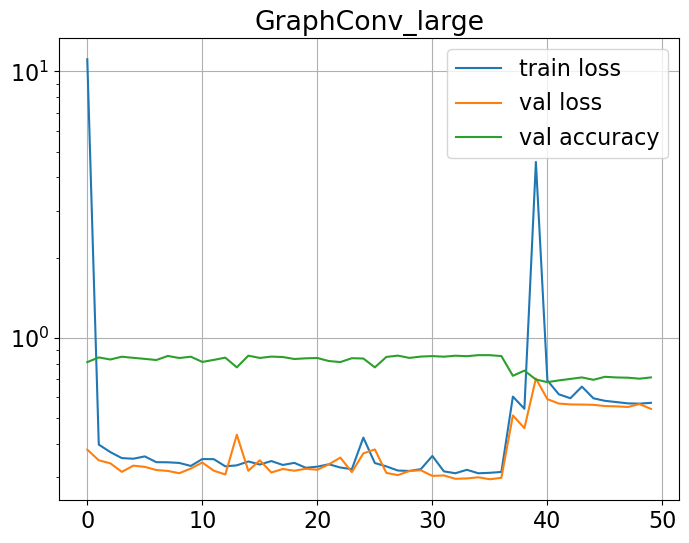

In [76]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.plot(val_accs)
plt.legend(["train loss", "val loss", "val accuracy"])
plt.title(label)
plt.semilogy()
plt.savefig(f"{label}_losses")

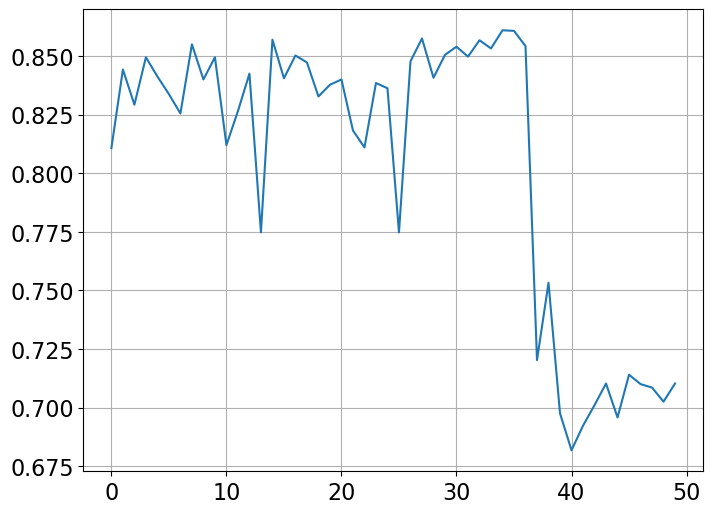

In [75]:
plt.plot(val_accs)